In [2]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import skhep_testdata, uproot, hist

In [3]:
def Smoothing(data, algorithm, endrule='median', twice=0):
    '''Main function. '''
    algorithms = {}
    if algorithm not in algorithms:
        fn = lambda d: d
        for action in algorithm[::-1]:
            if action.isdigit():
                fn = lambda d, p=fn, k=int(action), e=endrule: p(moving_median(d, k, e))
            elif action.isalpha():
                if action == 'H':
                    fn = lambda d, p=fn: p(hanning(d))
                elif action == 'G':
                    fn = lambda d, p=fn: p(hanning(d, True))
                elif action == 'Q':
                    fn = lambda d, p=fn: p(quadratic_interpolation(d))
            else:
                raise ValueError(f"Invalid action '{action}'")
        mod_data = fn(data)
    else:
        fn = algorithms[algorithm]
        mod_data = fn(data)
    mod_data = twicing(data, mod_data, fn, times=twice)
    return mod_data

def moving_median(data, window, endrule='median'):
    data = np.asarray(data, dtype=float)
    n = len(data)
    k2 = window // 2
    core = np.median(sliding_window_view(data, window), axis=1)

    new_data = np.empty_like(data, dtype=float)

    new_data[k2:n - k2] = core

    if endrule == 'keep':
        new_data[:k2] = data[:k2]
        new_data[-k2:] = data[-k2:]

    elif endrule == 'constant':
        left_median = np.median(data[:window])
        right_median = np.median(data[-window:])
        new_data[:k2] = left_median
        new_data[-k2:] = right_median

    elif endrule == 'median':
        for i in range(k2):
            new_data[i] = np.median(data[:2 * i + 1])
            new_data[-i - 1] = np.median(data[-(2 * i + 1):])
    else:
        raise ValueError(f"Unknown endrule: {endrule}")

    return new_data

def hanning(data, condition=False):
    data = np.asarray(data, dtype=float)

    windows = sliding_window_view(data, window_shape=3)
    smoothed_core = []

    for triplet in windows:
        a, b, c = triplet
        if condition:
            signs = np.sign([a, b, c])
            if np.all(signs != 0) and signs[0] == -signs[1] and signs[1] == -signs[2]:
                smoothed_core.append(0.25 * a + 0.5 * b + 0.25 * c)
            else:
                smoothed_core.append(b)
        else:
            smoothed_core.append(0.25 * a + 0.5 * b + 0.25 * c)

    smoothed_core = np.array(smoothed_core)

    result = np.empty_like(data)
    result[1 : -1] = smoothed_core
    result[0] = data[0]
    result[-1] = data[-1]

    return result

def quadratic_interpolation(y):
    y_out = np.array(y, float).copy()
    for i in range(2, len(y)-2):
        if (y[i-1] == y[i] == y[i+1]) and ((y[i-2] < y[i] and y[i+2] < y[i]) or (y[i-2] > y[i] and y[i+2] > y[i])):
            left_dist = abs(y[i-2] - y[i])
            right_dist = abs(y[i+2] - y[i])
            if left_dist >= right_dist:
                x_fit = [i - 2, i - 1, i + 2]
                y_fit = [y[i-2], y[i-1], y[i+2]]
                indices_to_update = [i, i + 1]
            else:
                x_fit = [i - 2, i + 1, i + 2]
                y_fit = [y[i-2], y[i+1], y[i+2]]
                indices_to_update = [i - 1, i]
            coeffs = np.polyfit(x_fit, y_fit, 2)
            poly_func = np.poly1d(coeffs)
            for index in indices_to_update:
                y_out[index] = poly_func(index)
    return np.array(y_out, float)

def twicing(original_data, smooth, algorithm, times=1):
    for _ in range(times):
        rough = original_data - smooth
        smooth = smooth + algorithm(rough)
    return smooth

In [4]:
mean = 0
std_dev = 1
size = 1000
data = np.random.normal(loc=mean, scale=std_dev, size=size)

In [5]:
Smoothing(data, '353QH', twice=1)

array([ 1.61795934e+00,  1.29437413e+00,  5.29746724e-01, -2.87524278e-02,
       -1.46209395e-01, -1.46209395e-01, -1.46209395e-01, -1.46209395e-01,
       -1.19041495e-01, -7.01438939e-02, -5.38523931e-02, -5.92905929e-02,
       -1.67962194e-01, -5.69786302e-01, -1.04741971e+00, -1.23190062e+00,
       -1.23190062e+00, -9.36704242e-01, -3.46311494e-01,  1.41454090e-02,
        1.44666468e-01,  3.16645874e-01,  5.37247102e-01,  6.58292929e-01,
        5.90967113e-01,  3.84474452e-01,  4.59703879e-01,  1.00340564e+00,
        1.29029397e+00,  7.98265044e-01, -3.06536095e-01, -1.36783234e+00,
       -1.59877689e+00, -9.08688413e-01,  1.23516897e-01,  8.16824836e-01,
        6.68992111e-01,  3.75109089e-02, -1.21667268e-01,  2.17681879e-01,
        4.44854170e-01,  6.21035894e-01,  1.03047559e+00,  1.35172128e+00,
        1.23692055e+00,  7.47389946e-01,  2.60690361e-01,  2.35780775e-02,
       -1.08933988e-01, -2.86469977e-01, -5.09029888e-01, -6.20309844e-01,
       -7.00629950e-01, -

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [57]:
def print_both(data, mod_data, bins, together, mean, std_dev):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    bins_number, s, e = bins
    x = np.linspace(s, e, 300)

    h = hist.Hist(hist.axis.Regular(bins_number, s, e))
    h.fill(data)
    h.plot(ax=axs[0])
    axs[0].plot(x, norm.pdf(x, mean, std_dev) * len(data) * (e - s) / bins_number,
                color='red', linestyle='--', label='Normal Dist')
    axs[0].legend()
    axs[0].set_title('Original Data')

    h2 = hist.Hist(hist.axis.Regular(bins_number, s, e))
    h2.fill(mod_data)
    h2.plot(ax=axs[1])
    axs[1].plot(x, norm.pdf(x, mean, std_dev) * len(mod_data) * (e - s) / bins_number,
                color='red', linestyle='--', label='Normal Dist')
    axs[1].legend()
    axs[1].set_title('Smoothed Data')

    mse = mean_squared_error(data, mod_data)
    mae = mean_absolute_error(data, mod_data)

    textstr = f'MSE: {mse:.4f}\nMAE: {mae:.4f}'
    axs[1].text(0.95, 0.95, textstr, transform=axs[1].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(facecolor='white', alpha=0.6))

    plt.tight_layout()
    plt.show()

In [59]:
bin = (200, -20, 20)
mean = 0
std_dev = 5
size = 10000
data = np.random.normal(loc=mean, scale=std_dev, size=size)

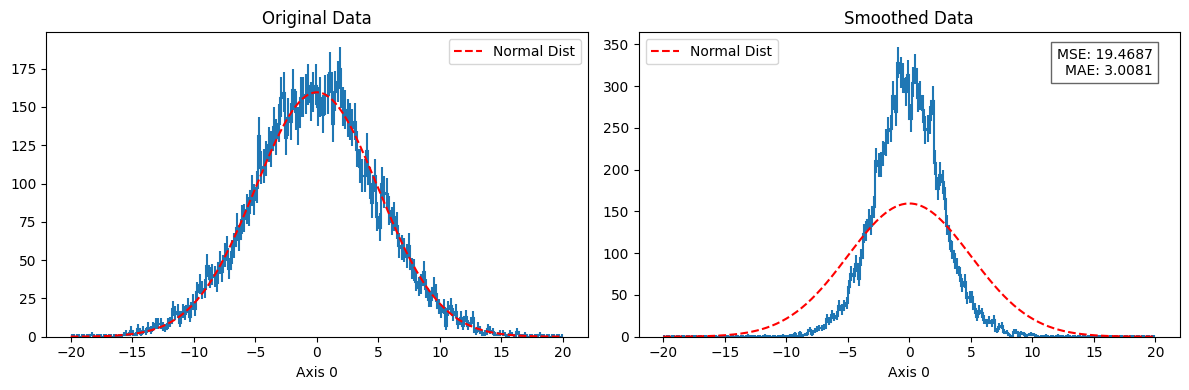

In [60]:
print_both(data, Smoothing(data, '353QH', twice=1), bin, 1, mean, std_dev)

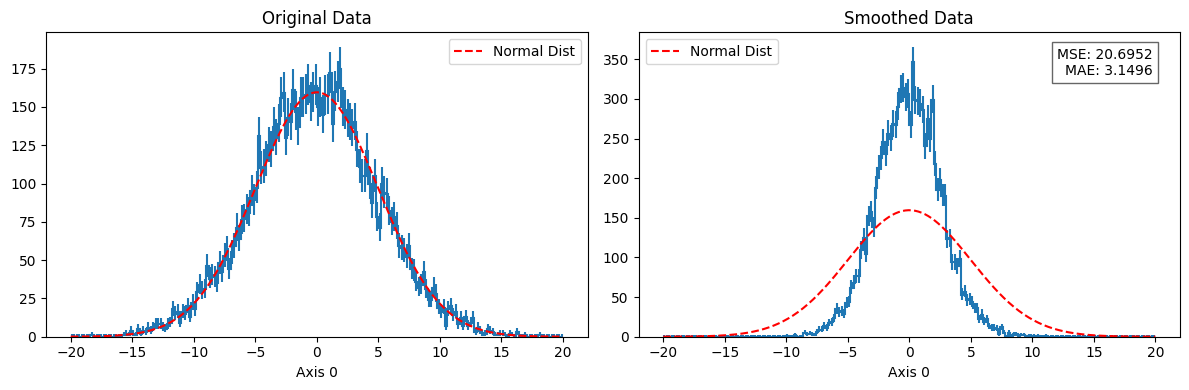

In [61]:
print_both(data, Smoothing(data, '53H', twice=1), bin, 1, mean, std_dev)

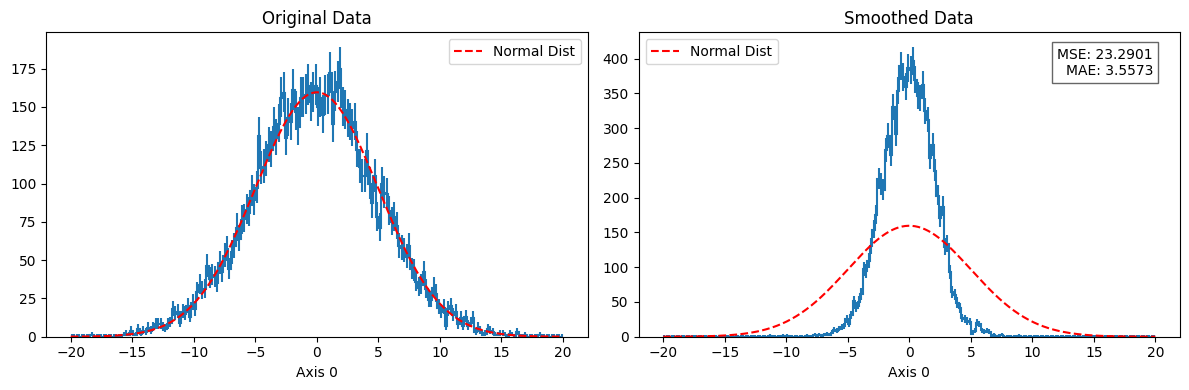

In [62]:
print_both(data, Smoothing(data, '95H', twice=1), bin, 1, mean, std_dev)

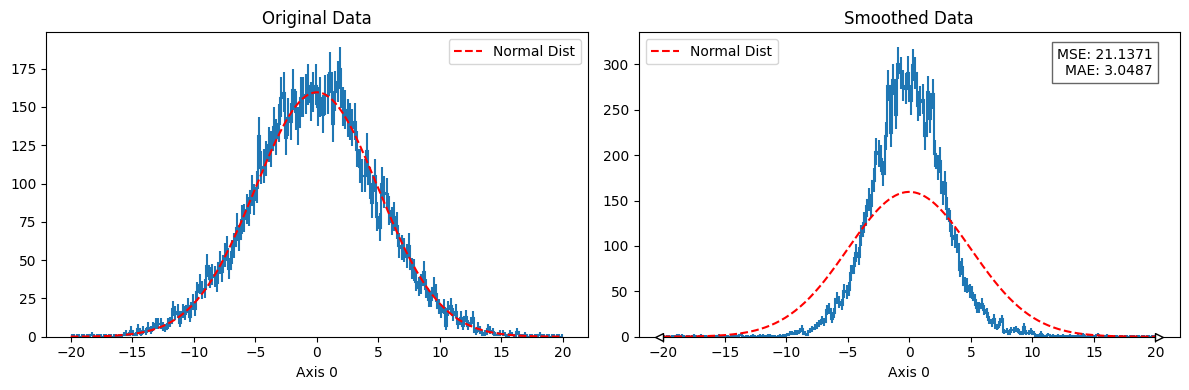

In [63]:
print_both(data, Smoothing(data, '3G53QH', twice=5), bin, 1, mean, std_dev)

In [80]:
tree = uproot.open(skhep_testdata.data_path("uproot-Zmumu.root"))["events"]
data = tree["M"].array()
bin = (80, 0, 120)

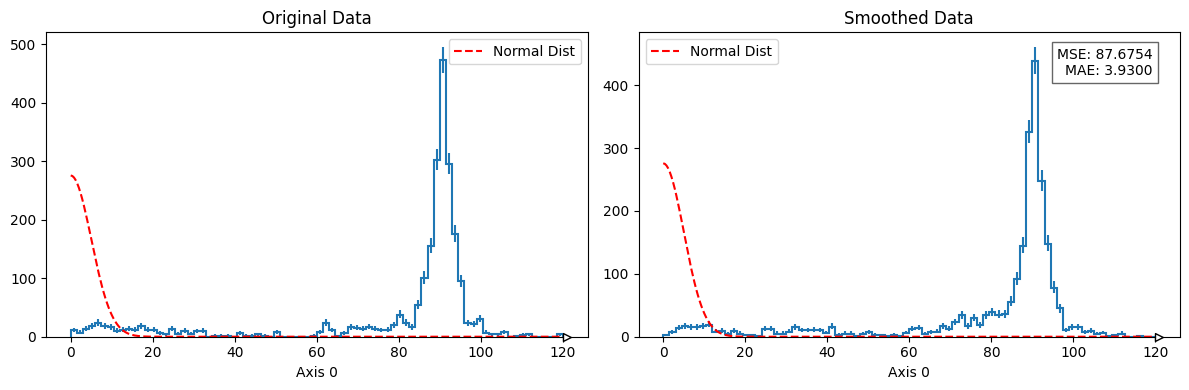

In [81]:
print_both(data, Smoothing(data, '353QH', twice=1), bin, 1, mean, std_dev)

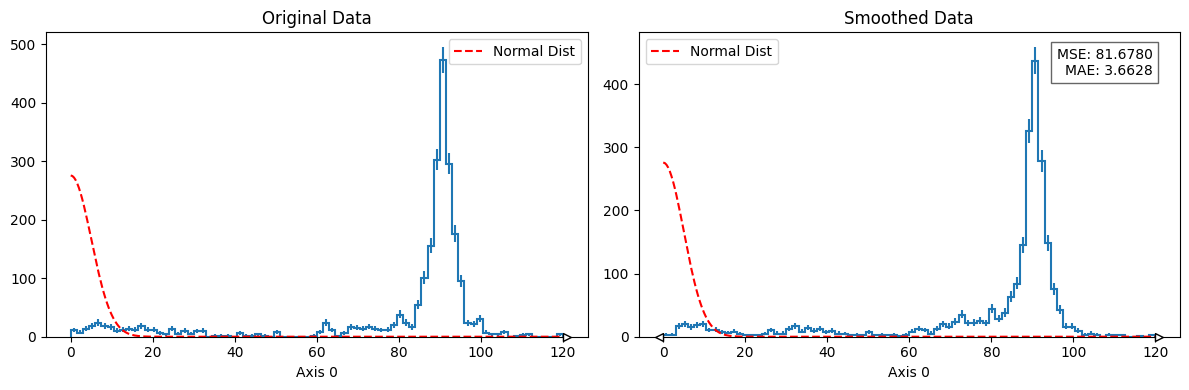

In [82]:
print_both(data, Smoothing(data, '3G53QH', twice=5), bin, 1, mean, std_dev)

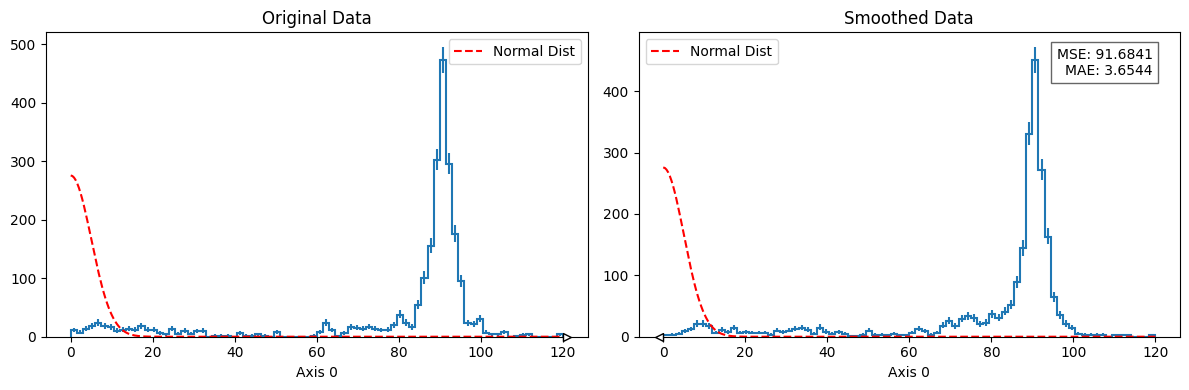

In [83]:
print_both(data, Smoothing(data, '53H', twice=1), bin, 1, mean, std_dev)

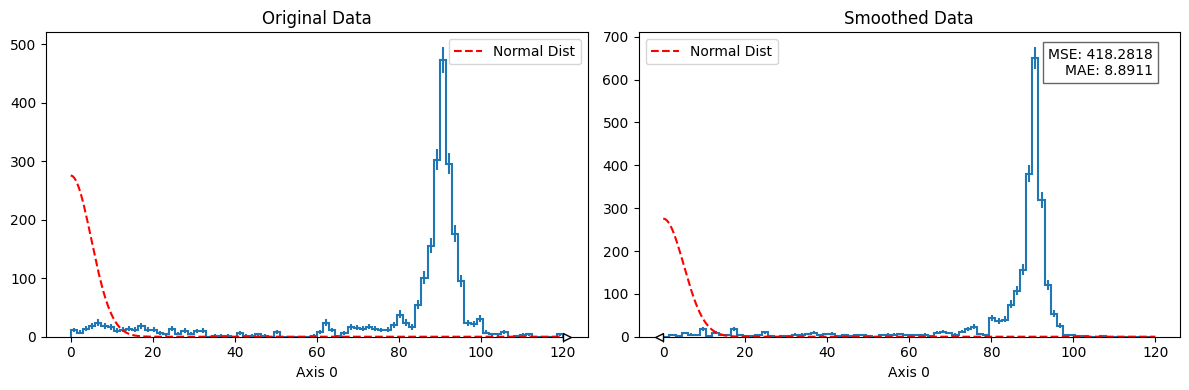

In [84]:
print_both(data, Smoothing(data, '95H', twice=1), bin, 1, mean, std_dev)